$\Large {\textbf{Monte-Carlo Simulation zum Landé-Versuch}}$

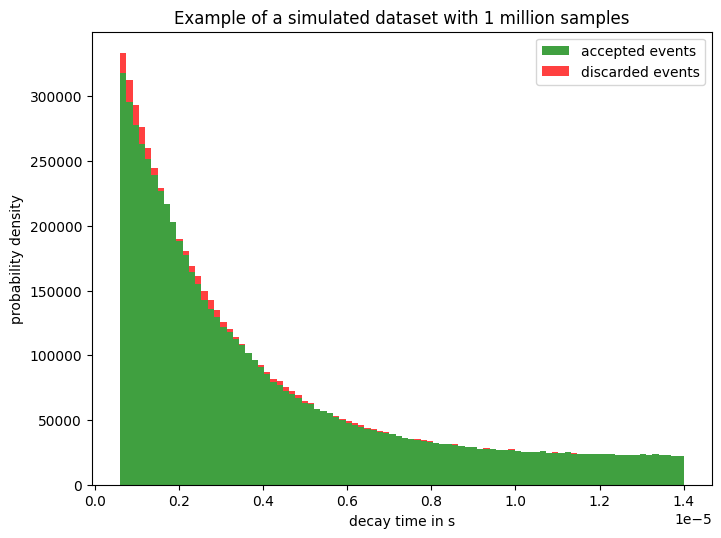

In [1]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from PhyPraKit.phyFit import mFit, hFit #requires iminuit
import pandas as pd
import scipy.stats as st
from scipy.special import lambertw

# > Define pdf for modulated exponential decay

def modulatedDecayPDF(t, tau=2.2e-6, fbg=0.3, a_bar = 0.08, delta = 0., omega = 3.467e+06, a = 0.6e-6, b = 14.0e-6):
    """
    :param t: decay time
    :param tau: expected mean of the decay time
    :param fbg: background
    :param a_bar: modulation amplitude
    :param delta: phase shift
    :param omega: precession angular frequency
    :param a: the minimum decay time which can be measured
    :param b: the maximum decay time which can be measured
    :return: probability for decay time t
    """
    pdf1 = np.exp(-t / tau) * (1 + a_bar * np.cos(omega * t + delta)) / ((np.exp(-b / tau) * ((omega * np.sin(b * omega + delta) * tau**2 - np.cos(b * omega + delta) * tau) * a_bar - omega**2 * tau**3 - tau) - np.exp(-a / tau) * ((omega * np.sin(a * omega + delta) * tau**2 - np.cos(a * omega + delta) * tau) * a_bar - omega**2 * tau**3 - tau))  / (omega**2 * tau**2 + 1))
    pdf2 = 1. / (b - a)
    return (1 - fbg) * pdf1 + fbg * pdf2

def majorante(t, tau=2.2e-6, fbg=0.3, a_bar = 0.08, delta = 0., omega = 3.467e+06, a = 0.6e-6, b = 14.0e-6):
    """
    :param t: decay time
    :return: majorante for modulatedDecayPDF
    """
    df1 = np.exp(-t / tau) * (1. + a_bar) / ((np.exp(-b / tau) * ((omega * np.sin(b * omega + delta) * tau**2 - np.cos(b * omega + delta) * tau) * a_bar - omega**2 * tau**3 - tau) - np.exp(-a / tau) * ((omega * np.sin(a * omega + delta) * tau**2 - np.cos(a * omega + delta) * tau) * a_bar - omega**2 * tau**3 - tau))  / (omega**2 * tau**2 + 1))
    df2 = 1. / (b - a)
    return (1. - fbg) * df1 + fbg * df2

def DistributionFunction(t, tau=2.2e-6, fbg=0.3, a_bar = 0.08, delta = 0., omega = 3.467e+06, a = 0.6e-6, b = 14.0e-6):
    """
    :param t: decay time
    :return: integrates majorante from a to t
    """
    c = ((np.exp(-b / tau) * ((omega * np.sin(b * omega + delta) * tau**2 - np.cos(b * omega + delta) * tau) * a_bar - omega**2 * tau**3 - tau) - np.exp(-a / tau) * ((omega * np.sin(a * omega + delta) * tau**2 - np.cos(a * omega + delta) * tau) * a_bar - omega**2 * tau**3 - tau))  / (omega**2 * tau**2 + 1))
    c_1 = tau * (1. - fbg) * (1. + a_bar) / c
    c_2 = fbg * 1. / (b-a)
    c_3 = c_1 * np.exp(-a / tau) - c_2 * a
    return -c_1 * np.exp(-t / tau) + c_2 * t + c_3

def inverseDistributionFunction(r, tau=2.2e-6, fbg=0.3, a_bar = 0.08, delta = 0., omega = 3.467e+06, a = 0.6e-6, b = 14.0e-6):
    """
    :param r: density value
    :return: inverse function value of the cummulative majorante
    """
    c = ((np.exp(-b / tau) * ((omega * np.sin(b * omega + delta) * tau**2 - np.cos(b * omega + delta) * tau) * a_bar - omega**2 * tau**3 - tau) - np.exp(-a / tau) * ((omega * np.sin(a * omega + delta) * tau**2 - np.cos(a * omega + delta) * tau) * a_bar - omega**2 * tau**3 - tau))  / (omega**2 * tau**2 + 1))
    c_1 = tau * (1. - fbg) * (1. + a_bar) / c
    c_2 = fbg * 1. / (b-a)
    c_3 = c_1 * np.exp(-a / tau) - c_2 * a
    return tau * np.real(lambertw((c_1 * np.exp((c_3-r)/(c_2 * tau)))/(c_2 * tau))) + (r - c_3) / c_2

def acceptProbability(tau=2.2e-6, fbg=0.3, a_bar = 0.08, delta = 0., omega = 3.467e+06, a = 0.6e-6, b = 14.0e-6):
    """
    :return: probability of a decay time being accepted in the importance sampling
    """
    majorante_integral = DistributionFunction(b, tau, fbg, a_bar, delta, omega, a, b)
    return 1 / majorante_integral

# > Define simulated data generator

def simulatedDataGenerator(tau_real, fbg_real, a_bar_real, delta_real, omega_real, a_real, b_real, n, calibratedProbabilities):
    """
    :param omega_real: array containing all possible precession angular frequencies
    :param n: MC-sampling size
    :param calibratedProbabilities: calibrated probabilities for the occurrence of different omegas during importance sampling
    :return: array with simulated decay times
    """
    m = n + 10000 # > Ensures that enough samples get generated. This should be a pretty generous estimation if realistic parameters are used.
    omega_samples = np.random.choice(omega_real, size = m, p = calibratedProbabilities)
    uniform_samples = np.random.uniform(low=0., high = DistributionFunction(b_real, tau_real, fbg_real, a_bar_real, delta_real, omega_samples, a_real, b_real), size = m)
    t_samples = inverseDistributionFunction(uniform_samples, tau_real, fbg_real, a_bar_real, delta_real, omega_samples, a_real, b_real)
    y_samples = np.random.uniform(low=0., high=1., size=m)
    majorante_samples = majorante(t_samples, tau_real, fbg_real, a_bar_real, delta_real, omega_samples, a_real, b_real)
    modulatedDecayPDF_samples = modulatedDecayPDF(t_samples, tau_real, fbg_real, a_bar_real, delta_real, omega_samples, a_real, b_real)
    dT = t_samples[(y_samples * majorante_samples) <= modulatedDecayPDF_samples]
    return dT[:n]
    
# > Generates histogram data to visualize the importance sampling method

def histDataGenerator(tau_real, fbg_real, a_bar_real, delta_real, omega_real, a_real, b_real, n, calibratedProbabilities):
    """
    :param omega_real: array containing all possible precession angular frequencies
    :param n: MC-sampling size
    :return: two arrays with accepted and discarded decay times
    """
    omega_samples = np.random.choice(omega_real, size = n, p = calibratedProbabilities)
    uniform_samples = np.random.uniform(low=DistributionFunction(a_real, tau_real, fbg_real, a_bar_real, delta_real, omega_samples, a_real, b_real), high=DistributionFunction(b_real, tau_real, fbg_real, a_bar_real, delta_real, omega_samples, a_real, b_real), size = n)
    t_samples = inverseDistributionFunction(uniform_samples, tau_real, fbg_real, a_bar_real, delta_real, omega_samples, a_real, b_real)
    y_samples = np.random.uniform(low=0., high=1., size=n)
    majorante_samples = majorante(t_samples, tau_real, fbg_real, a_bar_real, delta_real, omega_samples, a_real, b_real)
    modulatedDecayPDF_samples = modulatedDecayPDF(t_samples, tau_real, fbg_real, a_bar_real, delta_real, omega_samples, a_real, b_real)
    dT = t_samples[(y_samples * majorante_samples) <= modulatedDecayPDF_samples]
    return dT, t_samples[(y_samples * majorante_samples) > modulatedDecayPDF_samples]
    
# > Define simulated data fit

def simulatedDataFit(dT, bin_count, delta_fit, omega_fit, a_fit, b_fit, show_plot):
    """
    :param dT: array with simulated decay times
    :param bin_count: amount of bins to be used for the histrogram fit
    :param delta_fit: fixed value for phase shift to be used in fits
    :param omega_fit: fixed value for the precession angular frequency to be used in fit
    :param a_fit: fixed value for the minimum decay time to be used in fit
    :param b_fit: fixed value for the maximum decay time to be used in fit
    :param show_plot: show plot of the histogram fit
    :return: Log-Likelihood ratio test statistic Delta
    """
    # > Perform fit without modulation
    bin_contents, bin_edges =  np.histogram(dT, bin_count)
    results1 = hFit(modulatedDecayPDF,
           bin_contents, bin_edges,
           p0 = [2.2e-6, 0.3, 0., delta_fit, omega_fit, a_fit, b_fit], # initial guess of parameters
           limits= ('fbg', 0., 1.),   # parameter limits
           fixPars = ['a_bar','delta','omega','a', 'b'],      # fix parameter(s)
           plot = False)
    # > Get results from first fit
    pvals1, perrs1, cor1, gof1, pnams1 = results1.values()        
    # > Perform fit with modulation with tau and fbg from previous fit
    results2 = hFit(modulatedDecayPDF,
           bin_contents, bin_edges,
           p0 = [pvals1[0], pvals1[1], 0.2, delta_fit, omega_fit, a_fit, b_fit], # initial guess of parameters
           limits= ('a_bar', 0., 1.),   # parameter limits
           fixPars = ['tau','fbg','delta','omega','a','b'], # fix parameter(s)
           plot=show_plot,             # plot data and model
           plot_band=show_plot,        # plot model confidence-band
           plot_cor=show_plot,         # plot profile likelihood and contours
           #plot_residual=True,         # plot residual
           axis_labels=['lifetime  ' + '$\Delta$t [s]',
                           'Probability Density  pdf($\Delta$t; *p)'],
           data_legend = '$\mu$ lifetime data',
           model_legend = 'modulated decay + flat background')
    # > Get results from second fit
    pvals2, perrs2, cor2, gof2, pnams2 = results2.values()
    # > Get optimal values from previous fit
    a_bar = pvals2[0]
    tau = pvals2[1]
    fbg = pvals2[2]
    delta = pvals2[3]
    omega = pvals2[4]
    a = pvals2[5]
    b = pvals2[6]
    # > Calculate the Log-Likelihoods
    non_modulated_probabilities = modulatedDecayPDF(dT, tau, fbg, 0., delta, omega, a, b)
    modulated_probabilities = modulatedDecayPDF(dT, tau, fbg, a_bar, delta, omega, a, b)
    non_modulated_log_likelihood = np.sum(np.log(non_modulated_probabilities))
    modulated_log_likelihood = np.sum(np.log(modulated_probabilities))
    # > Calculate the negative Log-Likelihood ratio of the two models (Wilks' Theorem)
    Delta = -2*(non_modulated_log_likelihood - modulated_log_likelihood)
    return(Delta)

# > Read in data for the magnetfic field

df = pd.read_parquet("1M_B_samples.parquet")

# > Specify simulation parameters

tau_real = 2.2e-6
fbg_real = 0.3 # should not be set to zero! 0.01 is OK though
a_bar_real = 0.03
delta_real = 0.
omega_real = df['omega'].to_numpy()
omega_mean = np.mean(omega_real) # the mean value of omega will be fixed in the histogram fit
#omega_real = np.asarray([omega_mean]) # alternatively set omega to mean for a homogeneous magnetic field
a_real = 0.6e-6
b_real = 14.0e-6
n = 32000 # amount of samples per dataset
bincount = 90 # amount of bins used for the histogram fit
show_plot = False # show plot of the histogram fit, script is faster with show_plot set to False
N = 10000 # amount of datasets

calibratedProbabilities = 1 / acceptProbability(tau_real, fbg_real, a_bar_real, delta_real, omega_real, a_real, b_real) / np.sum(1 / acceptProbability(tau_real, fbg_real, a_bar_real, delta_real, omega_real, a_real, b_real)) # contains calibrated probabilities for the different omegas

# > Plot an example of the generated data

dT_accepted, dT_discarded = histDataGenerator(tau_real, fbg_real, a_bar_real, delta_real, omega_real, a_real, b_real, 1000000, calibratedProbabilities)

plt.figure(figsize=(8,6), dpi = 100)
plt.hist([dT_accepted, dT_discarded], stacked = True, density = True, color=['green','red'], alpha = 0.75, bins= bincount, label = ['accepted events','discarded events'])
plt.xlabel('decay time in s')
plt.ylabel('probability density')
plt.legend()
plt.title('Example of a simulated dataset with 1 million samples')
plt.show()

In [2]:
# > Generate N datasets and calculate the Log-Likelihood test statistics

test_statistics = []

for j in range(0, N):
    clear_output(wait=True)
    dT = simulatedDataGenerator(tau_real, fbg_real, a_bar_real, delta_real, omega_real, a_real, b_real, n, calibratedProbabilities)
    # > Calculate test statistics
    test_statistics.append(simulatedDataFit(dT, bincount, delta_real, omega_mean, a_real, b_real, show_plot))
    p = 1 - st.chi2.cdf(test_statistics, 1)
    z = st.norm.ppf(1 - p)
    z = z[np.abs(z) < np.inf]
    delta_mean = np.mean(test_statistics)
    delta_std = np.std(test_statistics)
    z_mean = np.mean(z)
    z_std = np.std(z)
    # > Print results
    print("%s out of %s datasets evaluated:" %(j+1, N))
    print("\t Average Delta with standard deviation:   %s ± %s"   % ("{:.4f}".format(delta_mean),"{:.4f}".format(delta_std)))
    print("\t Average z-score with standard deviation: %s ± %s"   % ("{:.4f}".format(z_mean),"{:.4f}".format(z_std)))

# > Save the results

#np.savetxt('results.txt', np.asarray(test_statistics), delimiter=',')

10000 out of 10000 datasets evaluated:
	 Average Delta with standard deviation:   7.7615 ± 5.2734
	 Average z-score with standard deviation: 2.3464 ± 1.0694
